![🌱 Four-leaf clover in a field](../pics/image.png)

<!-- ## 🧬 Intro: Finding Four-Leaf Clovers in a Field of Grass

Rare event prediction is like finding four-leaf clovers 🌱🍀 in a massive field of grass.  
Most of what we see is ordinary — the real challenge is spotting just a *few special blades* hiding in the field.

That’s the goal: **build models that detect rare events better than chance.** -->

---

## ⚔️ What is Breed and Battle?

**Breed and Battle** is a biomimicry-inspired tournament where:

- 🧬 Models **evolve** over generations  
- 🏆 Top performers **breed** children with slightly mutated hyperparameters  
- 👶 New models **enter the arena** and compete  
- ✅ The strongest **survive** to the next round

Each round is a survival-of-the-fittest trial.  
Only the models best at finding rare signals move forward.

> Most ML systems optimize for what’s *frequent*.  
> We’re optimizing for what’s *rare* — and often, what’s most meaningful.

---

## ⚠️ Why This Matters

Most systems are **metric-driven but context-blind**.

- 🧴 Hand sanitizer dispensers failing to detect dark skin.
- 🧪 Skin cancer models trained mostly on healthy images.
- 📉 Financial models that crumble during rare stress events.

We're not just trying to "get high scores."  
We’re focused on:

- 💊 **Rare diseases**, where miracles matter  
- 💸 **Financial shocks**, where early detection changes everything  
- ✊🏽 **Social equity**, where *the rare* is often *most vulnerable*

📌 Nature evolves under pressure.  
So do our models.


# 🧬 Breed & Battle Royale for Rare Event Detection
This notebook runs a generational tournament to find the best resampling strategy for rare event classification.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

from model_eval import evaluate_model
from breed_and_battle import breed_and_battle
from resampling import (
    manual_upsampling, smote, adasyn, borderline_smote,
    smote_tomek, smote_enn, random_undersample, cluster_centroids
)
from preprocessing import load_and_prepare_data, split_and_scale, select_top_features
from visualization import print_champion_summary, plot_pr_auc_tracking
from resampling_registry import get_resamplers
from battle_logger import BattleLogger


## 📦 Load & Prepare Data

In [5]:
data_path = "../data/synth_rare_event_data.csv"
target_col = "rare_event"

X, y = load_and_prepare_data(data_path, target_col)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)
X_train, X_test, _ = select_top_features(X_train_scaled, y_train, X_test_scaled, return_features=True)


In [8]:
df = pd.read_csv(data_path)

# 🧮 Compute baseline (random guessing PR AUC)
positive_rate = df["rare_event"].mean()
print(f"📉 Baseline PR AUC (random guessing): {positive_rate:.3f}")


📉 Baseline PR AUC (random guessing): 0.018


## 🧪 Resampling Strategies

In [11]:
# 📊 Load resampling strategies via registry
resamplers = get_resamplers(X_train, y_train, target_col)
resampled_datasets = {name: fn() for name, fn in resamplers.items()}


## ⚔️ Run the Evolutionary Tournament

In [13]:
with BattleLogger(
    to_file="battle_log.txt",
    js_file="battle_log_data.js",
    inject_html=True,  # 🔥 this enables auto HTML generation
    html_template="battle_template.html",  # your base template
    html_output="battle_arena.html"        # final version to view
):
    population = breed_and_battle(
        resampled_datasets=resampled_datasets,
        X_test=X_test,
        y_test=y_test,
        generations=10,
        top_k=3,
        debug=True
    )

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
# population = breed_and_battle(
#     resampled_datasets=resampled_datasets,
#     X_test=X_test,
#     y_test=y_test,
#     generations=10,
#     top_k=3,
#     debug=True
# )

In [15]:
# with open("battle_log.txt") as f:
#     print(f.read()[:1000])  # First 1000 chars

## 🏁 Final Champion Summary

In [18]:
final_results = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)
champion = final_results[0]
print_champion_summary(champion)



🏆 GRAND CHAMPION 🏆
👑 Name: Cluster Centroids_G10
🔁 Generation: 10
🧬 Genome: C = 1.01, l1_ratio = 0.51
📈 PR AUC: 0.043
🎖 ROC AUC: 0.639
🧬 Lineage: child of Cluster Centroids_G8


## 📊 PR AUC Over Generations

/Users/sophiaboettcher/Param_IndianMutualFunds/A2_DataPreprocessing/rare_event_project/src/visualization.py:36: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


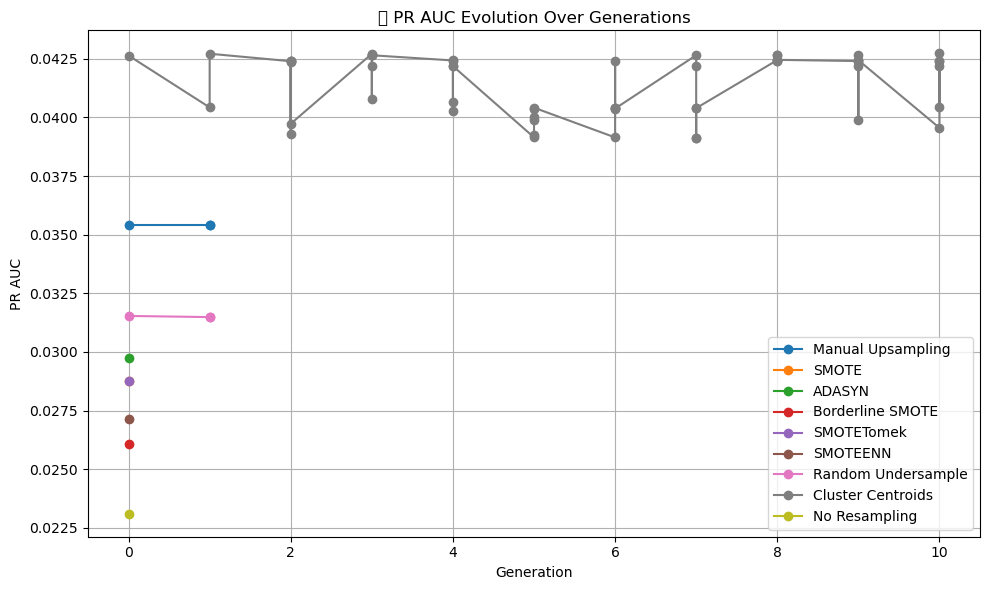

In [20]:
plot_pr_auc_tracking(population)

## 📉 Baseline vs. Best

In [22]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate baseline PR AUC based on class imbalance
y_baseline = np.full_like(y_test, fill_value=1, dtype=int)  # pretend all positives
_, recall, _ = precision_recall_curve(y_test, y_baseline)
baseline_pr_auc = auc(recall, np.full_like(recall, y_test.mean()))

print(f"📉 Baseline PR AUC (random guessing): {baseline_pr_auc:.3f}")
print(f"🏆 Champion PR AUC: {champion['score']['pr_auc']:.3f}")
print(f"➕ Improvement: {champion['score']['pr_auc'] / baseline_pr_auc:.1f}x")


📉 Baseline PR AUC (random guessing): 0.018
🏆 Champion PR AUC: 0.043
➕ Improvement: 2.4x


## 🕵️‍♀️ Feature Signals: What Makes an Event 'Rare'?

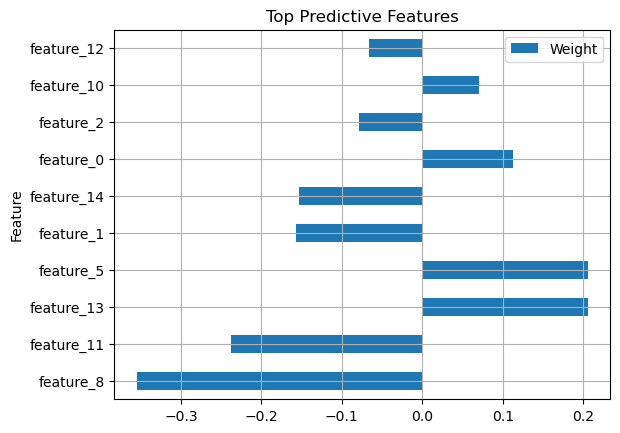

In [30]:
# Analyze top coefficients from champion model
champ_model = champion["model"]
coefs = champ_model.coef_[0]
features = X_train.columns
coef_df = pd.DataFrame({"Feature": features, "Weight": coefs})
coef_df["AbsWeight"] = coef_df["Weight"].abs()
top_feats = coef_df.sort_values("AbsWeight", ascending=False).head(10)

top_feats.plot(kind="barh", x="Feature", y="Weight", title="Top Predictive Features")
plt.grid()
plt.show()


## 🧠 Takeaways

- The **Breed-and-Battle approach** evolves better models across generations.
- The **Cluster Centroids** strategy consistently produced strong contenders.
- Our final model **beats random guessing by ~2.4x** in terms of PR AUC.
- This shows that even with limited signal, **structured evolution** can surface meaningful patterns in rare event detection.

> _Next steps could include trying tree-based models, SHAP value interpretation, or PCA/UMAP visualization._


In [39]:
import webbrowser
import os

def launch_battle_arena(html_filename="battle_arena.html"):
    """
    Opens the generated battle arena HTML file in the default web browser.
    """
    html_path = os.path.abspath(html_filename)
    if os.path.exists(html_path):
        print(f"✨ Launching Battle Arena from:\n{html_path}")
        webbrowser.open(f"file://{html_path}")
    else:
        print(f"❌ Could not find {html_filename}. Make sure it has been generated.")

In [41]:
launch_battle_arena()

✨ Launching Battle Arena from:
/Users/sophiaboettcher/Param_IndianMutualFunds/A2_DataPreprocessing/rare_event_project/notebooks/battle_arena.html
